In [11]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import json

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [12]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_PBBP2.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2007-1,58479296,2007-01-01
1,2007-2,92231362,2007-02-01
2,2007-3,372206635,2007-03-01
3,2007-4,3145042961,2007-04-01
4,2007-5,1875872254,2007-05-01


In [23]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()
json_data = dts.to_json(date_format='iso')
print(json_data)
with open('./datasets/pbbp2.json', 'w') as f:
    json.dump(json_data, f) 

{"2007-01-01T00:00:00.000":58479296,"2007-02-01T00:00:00.000":92231362,"2007-03-01T00:00:00.000":372206635,"2007-04-01T00:00:00.000":3145042961,"2007-05-01T00:00:00.000":1875872254,"2007-06-01T00:00:00.000":416791525,"2007-07-01T00:00:00.000":1129831713,"2007-08-01T00:00:00.000":9024652013,"2007-09-01T00:00:00.000":515482823,"2007-10-01T00:00:00.000":163580997,"2007-11-01T00:00:00.000":163957616,"2007-12-01T00:00:00.000":121487192,"2008-01-01T00:00:00.000":600649724,"2008-02-01T00:00:00.000":109171216,"2008-03-01T00:00:00.000":576441924,"2008-04-01T00:00:00.000":1355618074,"2008-05-01T00:00:00.000":1430174571,"2008-06-01T00:00:00.000":1117959287,"2008-07-01T00:00:00.000":2499444459,"2008-08-01T00:00:00.000":12687531171,"2008-09-01T00:00:00.000":1431480275,"2008-10-01T00:00:00.000":401416179,"2008-11-01T00:00:00.000":389597684,"2008-12-01T00:00:00.000":555154954,"2009-01-01T00:00:00.000":305037896,"2009-02-01T00:00:00.000":170247419,"2009-03-01T00:00:00.000":281914133,"2009-04-01T00:00:

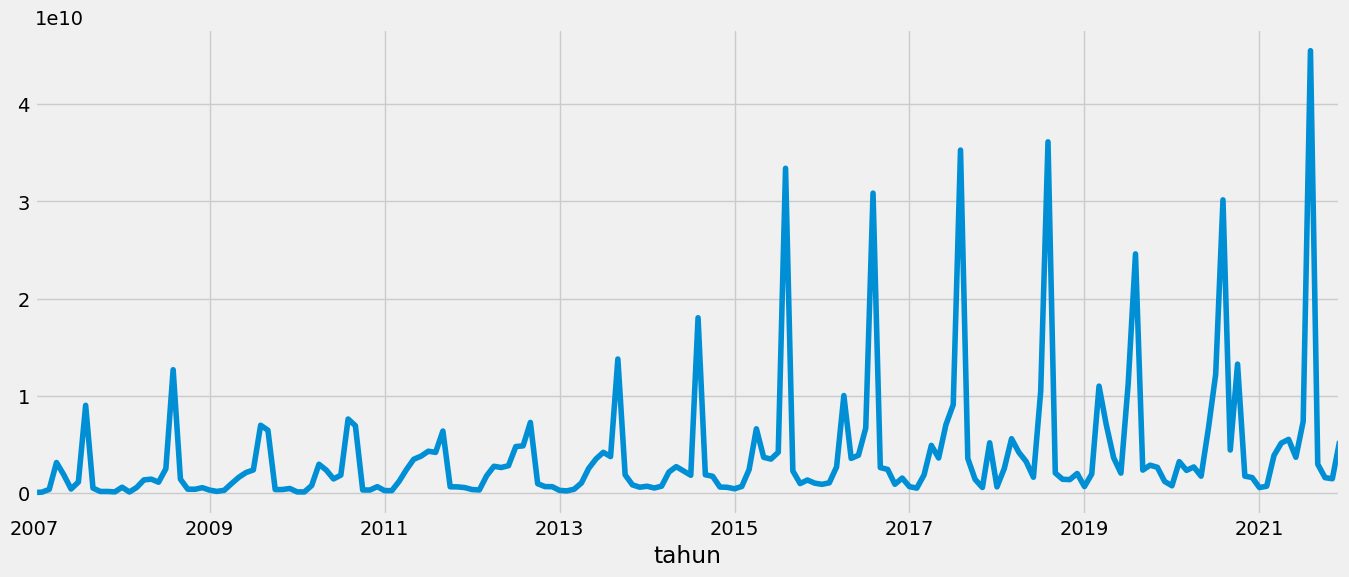

In [5]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [5]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [6]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = mod.fit()
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)


Best Result: [(0, 1, 1), (1, 1, 1, 12), 7804.821971368747]


In [ ]:
 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

# Plot model diagnostics

In [15]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,order=(0, 1, 1),seasonal_order=(1, 1, 1, 12),
                            enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  180
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3574.638
Date:                            Wed, 28 Dec 2022   AIC                           7157.276
Time:                                    07:26:05   BIC                           7169.398
Sample:                                01-01-2007   HQIC                          7162.200
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9911      0.023    -42.334      0.000      -1.037      -0.945
ar.S.L12       0.3973      0.169   

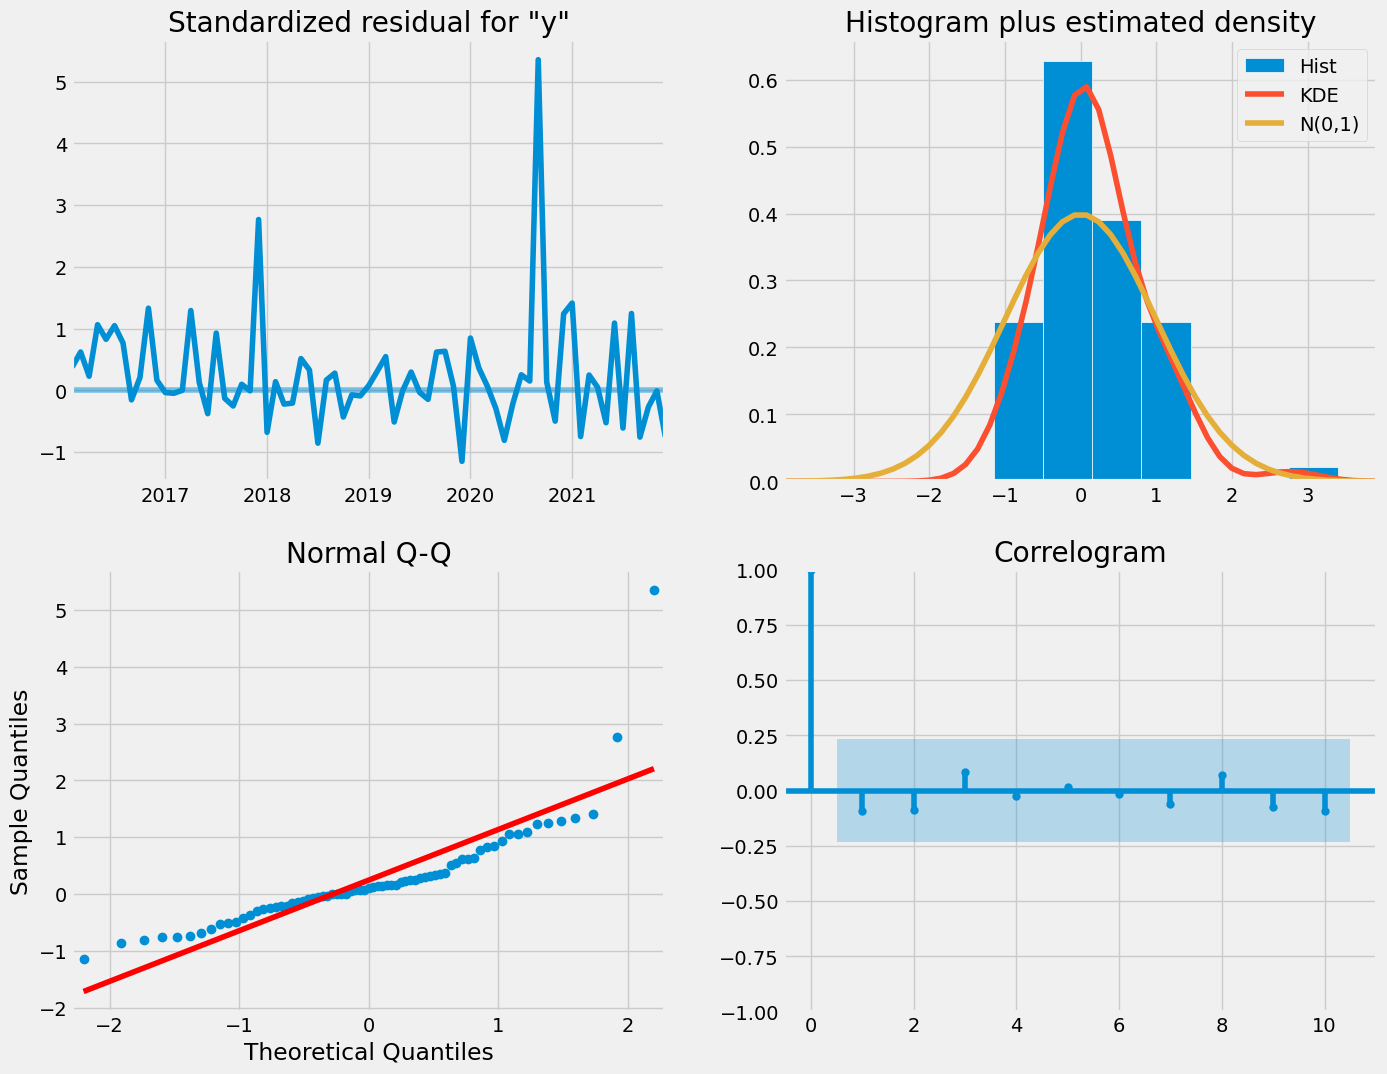

In [25]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

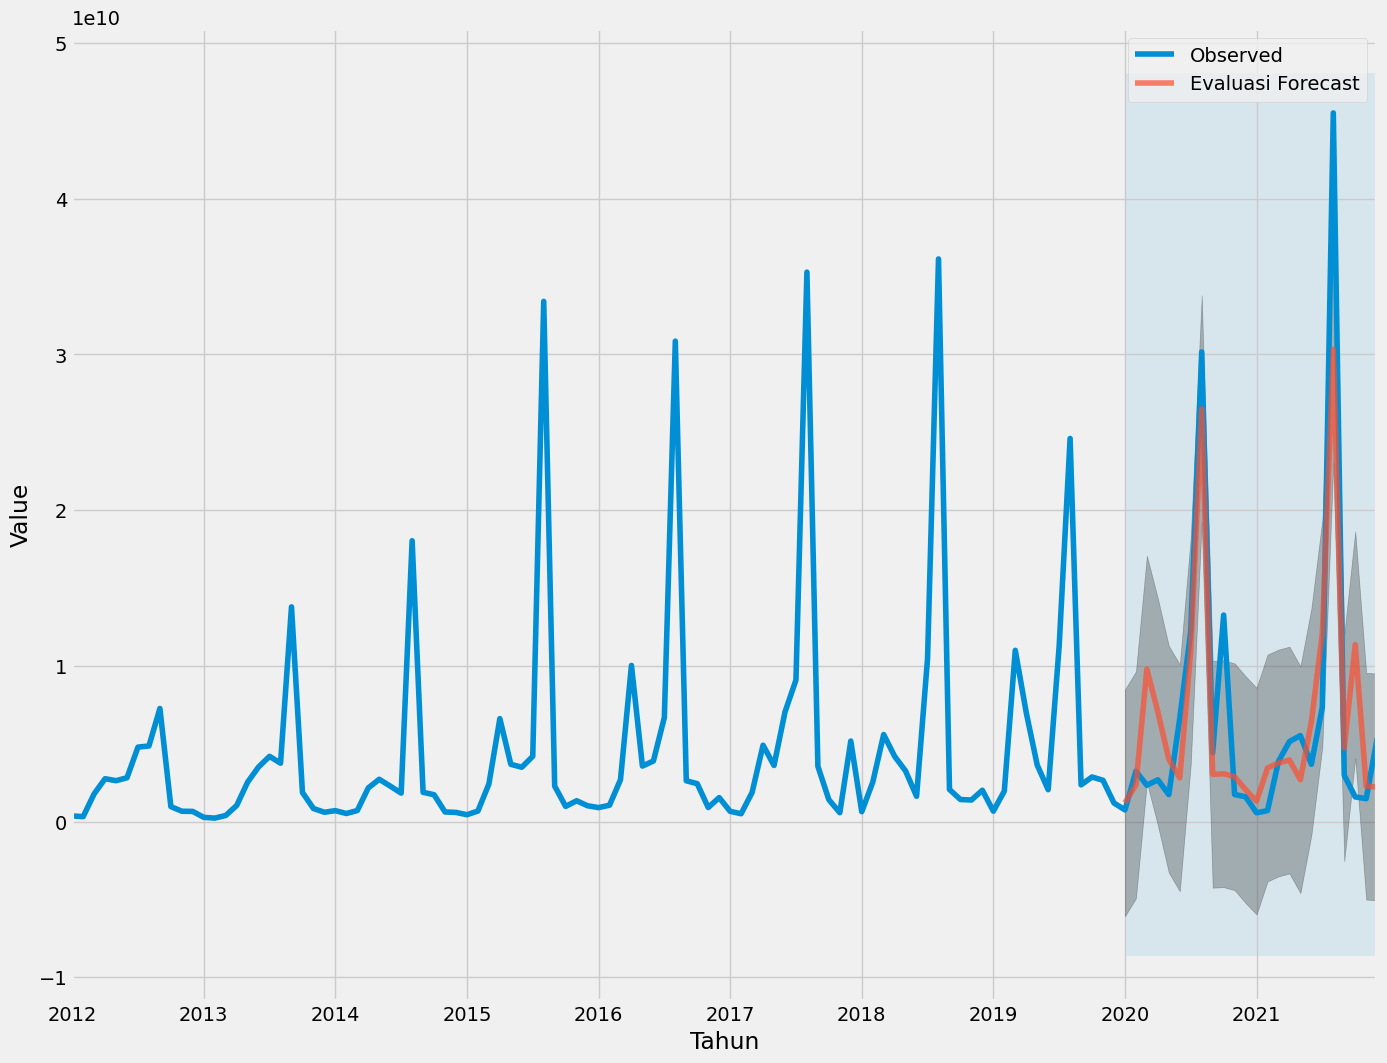

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [24]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=60, dynamic=False)
# Dapatkan interval
pred_ci = pred_uc.conf_int()
json_data = pred_uc.predicted_mean.to_json(date_format='iso')
print(json_data)
with open('./datasets/pbbp2_predicted.json', 'w') as f:
    json.dump(json_data, f) 

{"2022-01-01T00:00:00.000":1174809959.2201986313,"2022-02-01T00:00:00.000":1623592955.867964983,"2022-03-01T00:00:00.000":4649961779.6865291595,"2022-04-01T00:00:00.000":5607366292.025352478,"2022-05-01T00:00:00.000":5487015445.894777298,"2022-06-01T00:00:00.000":4418782824.8928318024,"2022-07-01T00:00:00.000":8608615199.9928741455,"2022-08-01T00:00:00.000":42378071625.2201461792,"2022-09-01T00:00:00.000":3657392359.6209888458,"2022-10-01T00:00:00.000":3224648876.1122088432,"2022-11-01T00:00:00.000":2099603088.2347044945,"2022-12-01T00:00:00.000":5121291737.5235109329,"2023-01-01T00:00:00.000":1635419420.7207443714,"2023-02-01T00:00:00.000":2207878945.8048834801,"2023-03-01T00:00:00.000":5177409272.998878479,"2023-04-01T00:00:00.000":6011713181.0998592377,"2023-05-01T00:00:00.000":5690953740.2824144363,"2023-06-01T00:00:00.000":4929561392.4786977768,"2023-07-01T00:00:00.000":9324142040.8786869049,"2023-08-01T00:00:00.000":41353641296.3074951172,"2023-09-01T00:00:00.000":4150332425.1513

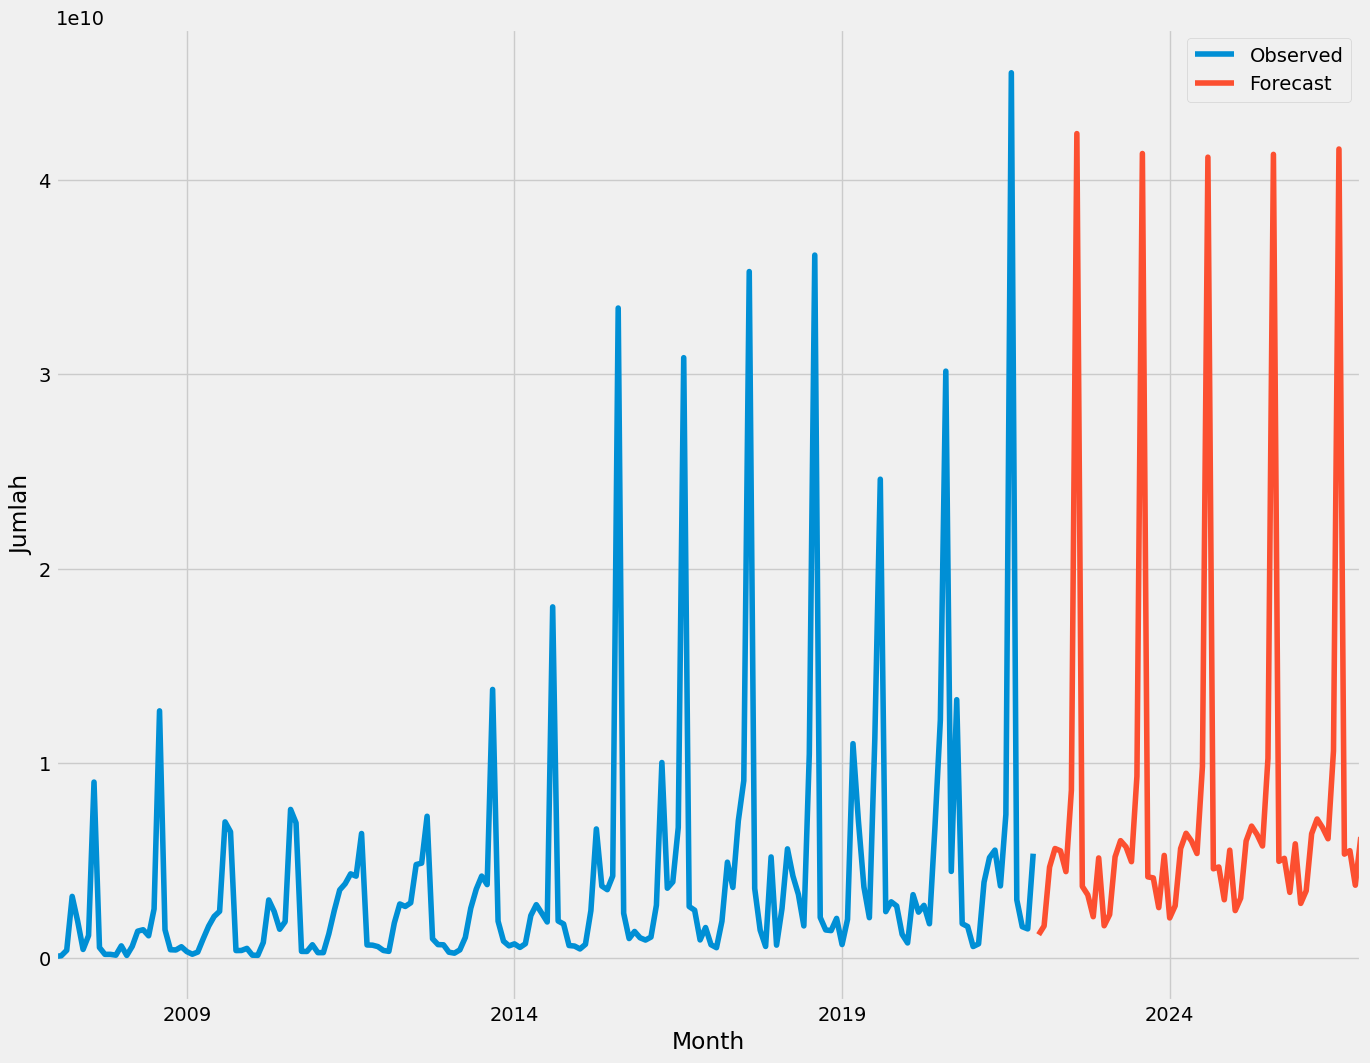

In [19]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()